<a href="https://colab.research.google.com/github/nheisler/Artificialis/blob/main/NFT_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import cv2
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

FINAL_IMAGE_COUNT = 2000
IMAGE_TYPE = 'Mountains'
content_path = '/content/gdrive/My Drive/Landscape AI/' + IMAGE_TYPE

training_data = []
y_data = []
num_images = 0

for img in os.listdir(content_path):
  pic = cv2.imread(os.path.join(content_path, img))
  pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
  pic = cv2.resize(pic, (256,256))
  training_data.append(pic)
  y_data.append(0)
  num_images = num_images + 1

def carry_images():
  Xtrain = np.array(training_data)
  Ytrain = np.array(y_data)
  index = np.where(Ytrain == 0)
  index = index[0]
  Xtrain = Xtrain[index, :,:,:]

  X = Xtrain.astype('float32')
  X = (X-127.5) / 127.5
  return X

print(carry_images().shape)

(102, 256, 256, 3)


In [ ]:
%cd /content/gdrive/My\ Drive/GANResults

/content/gdrive/My Drive/GANResults


In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import (Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten)

def imageGenerator():
  generator = tf.keras.Sequential()
  generator.add(Dense(256*32*32, input_shape=(100,)))
  generator.add(LeakyReLU())
  generator.add(Reshape((32,32,256)))
  generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Conv2D(3, kernel_size=3, padding = "same", activation='tanh'))

  return (generator)

generator_model = imageGenerator()
generator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 262144)            26476544  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 262144)            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 128)      295040    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 128)    147584    
 ranspose)                                              

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


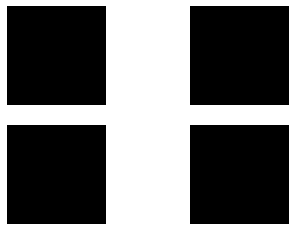

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generator_data_entry(samples):
  X = np.random.randn(100 * samples)
  X = X.reshape(samples, 100)
  return X

def create_fake_data(generator_model, samples):
  input = generator_data_entry(samples)
  X = generator_model.predict(input)
  y = np.zeros((samples, 1))
  return X,y

num_samples = 4
X,_ = create_fake_data(generator_model, num_samples)

for i in range(num_samples):
  plt.subplot(2,2,1+i)
  plt.axis('off')
  plt.imshow(X[i])

In [ ]:
from keras.optimizers import adam_v2

def image_discriminator():
  discriminator = tf.keras.Sequential()
  discriminator.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (256,256,3)))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Conv2D(256, kernel_size=3,strides=(2,2), padding = "same"))
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.4))
  discriminator.add(Dense(1, activation='sigmoid'))

  opt = tf.optimizers.Adam(lr=0.0002 ,beta_1=0.5)
  discriminator.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])
  return discriminator

discriminator_model = image_discriminator()
discriminator_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256, 256, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import random

def carry_real_data(dataset, samples):
  ix = np.random.randint(0, dataset.shape[0], samples)
  X = dataset[ix]
  y = np.ones((samples, 1))
  return X, y

def carry_fake_data(samples):
  X = np.random.rand(256 * 256 * 3 * samples)
  X = -1 + X * 2
  X = X.reshape((samples, 256,256,3))
  y = np.zeros((samples, 1))
  return X,y

In [ ]:
def train_discriminator(model, dataset, iterations=20, batch=128):
  half_batch = int(batch/2)

  for i in range(iterations):
    X_real, y_real = carry_real_data(dataset, half_batch)
    _, acc_real = model.train_on_batch(X_real, y_real)

    X_fake, y_fake = carry_fake_data(half_batch)
    _, acc_fake = model.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

dataset = carry_images()
train_discriminator(discriminator_model, dataset)

1 Real:51.5625, Fake:0.0
2 Real:100.0, Fake:0.0
3 Real:100.0, Fake:100.0
4 Real:95.3125, Fake:100.0
5 Real:98.4375, Fake:100.0
6 Real:98.4375, Fake:100.0
7 Real:100.0, Fake:100.0
8 Real:98.4375, Fake:100.0
9 Real:100.0, Fake:100.0
10 Real:100.0, Fake:100.0
11 Real:100.0, Fake:100.0
12 Real:100.0, Fake:100.0
13 Real:100.0, Fake:100.0
14 Real:100.0, Fake:100.0
15 Real:100.0, Fake:100.0
16 Real:100.0, Fake:100.0
17 Real:100.0, Fake:100.0
18 Real:100.0, Fake:100.0
19 Real:100.0, Fake:100.0
20 Real:100.0, Fake:100.0


In [ ]:
def create_gan(discriminator, generator):
  discriminator.trainable=False
  gan = tf.keras.Sequential()
  gan.add(generator)
  gan.add(discriminator)

  opt = tf.keras.optimizers.Adam(lr=0.0002,beta_1=0.5)
  gan.compile(loss = "binary_crossentropy", optimizer = opt)

  return gan

gan = create_gan(discriminator_model, generator_model)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       27070211  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 780545    
                                                                 
Total params: 27,850,756
Trainable params: 27,070,211
Non-trainable params: 780,545
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def show_generated_images(fake_data, out_folder, epoch):
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  fake_data = (fake_data + 1) / 2.0

  for i in range(len(fake_data)):
    plt.imshow(fake_data[i])
    plt.axis('off')
    plt.text(10, 25, 'Artificialis', style='italic', color='white', family='fantasy')
    name = str(out_folder) + 'Artificialis_' + IMAGE_TYPE + '_' + str(epoch) + str(i) + '.png'
    plt.savefig(name, bbox_inches='tight')
    plt.close()

In [ ]:
def evaluate_and_save(generator_model, epoch, half_dataset):
  #now = datetime.now()
  #now = now.strftime("%Y%m%d_%H%M%S")
  #name = 'Models/' + str(epoch) + '_' + str(now)+"_generator_model_" + '.h5'
  #generator_model.save(name)

  X_real, Y_real = carry_real_data(dataset, half_dataset)
  X_fake, Y_fake = create_fake_data(generator_model, half_dataset)

  _, acc_real = discriminator_model.evaluate(X_real, Y_real)
  _, acc_fake = discriminator_model.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [ ]:
def training(data, generator_model, discriminator_model, epochs, n_batch, beginning=0):
  dimension_batch = int(data.shape[0]/n_batch)
  half_dataset = int(n_batch/2)
  image_out_folder = 'Images/'
  final = False

  for epoch in range(beginning, beginning + epochs):
    if epoch + 1 == epochs:
      image_out_folder = 'Final/'
      final = True
    for batch in range(n_batch):
      X_real, Y_real = carry_real_data(dataset, half_dataset)
      cost_discriminator_real, _ = discriminator_model.train_on_batch(X_real, Y_real)
      X_fake, Y_fake = create_fake_data(generator_model, half_dataset)

      cost_discriminator_fake, _ = discriminator_model.train_on_batch(X_fake, Y_fake)

      X_gan = generator_data_entry(half_dataset)
      Y_gan = np.ones((half_dataset, 1))

      cost_gan = gan.train_on_batch(X_gan, Y_gan)

      if final == True:
        final_x, final_y = create_fake_data(generator_model, FINAL_IMAGE_COUNT)
        show_generated_images(final_x, image_out_folder, epoch=epoch)

      if (epoch + 1) % 10 == 0:
        evaluate_and_save(generator_model, epoch=epoch, half_dataset=half_dataset)
        show_generated_images(X_fake, image_out_folder, epoch=epoch)

training(dataset, generator_model, discriminator_model, epochs=200, n_batch=64, beginning=0)

1/1 [==============================] - 0s 68ms/step - loss: 0.1577 - accuracy: 0.9688
Acc Real:87.5% Acc Fake:96.875%
1/1 [==============================] - 0s 66ms/step - loss: 0.1291 - accuracy: 0.9688
Acc Real:87.5% Acc Fake:96.875%
1/1 [==============================] - 0s 73ms/step - loss: 0.0201 - accuracy: 1.0000
Acc Real:53.125% Acc Fake:100.0%
1/1 [==============================] - 0s 76ms/step - loss: 0.2059 - accuracy: 0.9062
Acc Real:84.375% Acc Fake:90.625%
1/1 [==============================] - 0s 77ms/step - loss: 0.0987 - accuracy: 1.0000
Acc Real:96.875% Acc Fake:100.0%
1/1 [==============================] - 0s 75ms/step - loss: 0.1993 - accuracy: 0.9062
Acc Real:100.0% Acc Fake:90.625%
1/1 [==============================] - 0s 78ms/step - loss: 0.1448 - accuracy: 0.9688
Acc Real:93.75% Acc Fake:96.875%
1/1 [==============================] - 0s 76ms/step - loss: 0.1309 - accuracy: 0.9688
Acc Real:96.875% Acc Fake:96.875%
1/1 [==============================] - 0s 76ms/s